# Two Dimensional Sequential Gaussian Simulation

Sequential Gaussian simulation is a technique to "fill in" a grid representing the area of interest using a _smattering_ of observations, and a model of the observed trend.

The basic workflow:

1.  Modeling the measured variation using a semivariogram
2.  Using the semivariogram to perform interpolation by kriging
3.  Running simulations to estimate the spatial distribution of the variable(s) of interest

In [26]:
import os
from pathlib import Path
import time
import random

import numpy as np
import pandas as pd
import scipy.stats
import scipy.optimize
import scipy.interpolate
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt


## Sequential Gaussian Simulation (SGS)

1.  Define a grid
2.  Place z-transformed initial data into the nearest grid cells

_expects normally distributed data, if not use a z-score transformation before SGS and a back-transformation afterwards_

3.  Visit the rest of the grid cells _at random_ and perform kriging using all of the available data
4.  Back-transform the data to retrieve the approximate distribution

## Data

In [3]:
cluster_url = 'http://elearning.algonquincollege.com/coursemat/viljoed/gis8746/concepts/gslib/data/cluster.dat'

In [4]:
clstr = pd.read_csv(cluster_url, header=None, delim_whitespace=True, skiprows=7, names=['Xlocation', 'Ylocation', 'Primary', 'Secondary', 'Declustering Weight'])
clstr.head()

,Xlocation,Ylocation,Primary,Secondary,Declustering Weight
0,39.5,18.5,0.06,0.22,1.619
1,5.5,1.5,0.06,0.27,1.619
2,38.5,5.5,0.08,0.40,1.416
3,20.5,1.5,0.09,0.39,1.821
4,27.5,14.5,0.09,0.24,1.349


## Gridding

In [5]:
# 30 step between 0 and 50
nx, xsteps = 50, 30
ny, ysteps = 50, 30
xrng = np.linspace(0, nx, xsteps)
yrng = np.linspace(0, ny, ysteps)

## Randomization

Create a random path through the spatial domain.

* Create an index from flattened matrix
* Shuffle that index (randomization)
* Walk through the 2d grid...

In [6]:
N = xsteps * ysteps
idx = np.arange(N)

random.shuffle(idx)

path = list()
t = 0

for i in range(xsteps):
    for j in range(ysteps):
        path.append( [idx[t], (i, j), (xrng[i], yrng[j])] )
        t += 1

path.sort()

In [7]:
path[:10]

[[0, (9, 21), (15.517241379310343, 36.206896551724135)],
 [1, (0, 26), (0.0, 44.82758620689655)],
 [2, (14, 13), (24.137931034482758, 22.413793103448274)],
 [3, (28, 0), (48.275862068965516, 0.0)],
 [4, (28, 2), (48.275862068965516, 3.4482758620689653)],
 [5, (13, 28), (22.413793103448274, 48.275862068965516)],
 [6, (10, 20), (17.241379310344826, 34.48275862068965)],
 [7, (21, 27), (36.206896551724135, 46.55172413793103)],
 [8, (26, 17), (44.82758620689655, 29.310344827586206)],
 [9, (14, 10), (24.137931034482758, 17.241379310344826)]]

## Simulation

The `sgs()` function visits the cells in the grid at random, calculates a kriging estimate, adds that to the original data & etc.

In [8]:
locations = np.array(clstr[['Xlocation', 'Ylocation']])
variable = np.array(clstr['Primary'])

In [9]:
# transform data to normal dist
def to_norm( data, bins=12 ):
    mu = np.mean( data )
    sd = np.std( data )
    z = ( data - mu ) / sd
    f, inv = cdf( z, bins=bins )
    z = scipy.stats.norm(0,1).ppf( f[:,1] )
    z = np.where( z==np.inf, np.nan, z )
    z = np.where( np.isnan( z ), np.nanmax( z ), z )
    param = ( mu, sd )
    return z, inv, param, mu, sd
 
# transform data from normal dist back
def from_norm( data, inv, param, mu, sd ):
    h = fit( inv )
    f = scipy.stats.norm(0,1).cdf( data )
    z = [ h(i)*sd + mu for i in f ]
    return z

def fit( d ):
    x, y = d[:,0], d[:,1]
    def f(t):
        if t <= x.min():
            return y[ np.argmin(x) ]
        elif t >= x.max():
            return y[ np.argmax(x) ]
        else:
            intr = scipy.interpolate.interp1d( x, y )
            return intr(t)
    return f

def cdf( d, bins=12 ):
    N = len( d )
    counts, intervals = np.histogram( d, bins=bins )
    h = np.diff( intervals ) / 2.0
    f, finv = np.zeros((N,2)), np.zeros((N,2))
    idx, k, T = 0, 0, float( np.sum( counts ) )
    for count in counts:
        for i in range( count ):
            x = intervals[idx]+h[0]
            y = np.cumsum( counts[:idx+1] )[-1] / T
            f[k,:] = x, y 
            finv[k,:] = y, x
            k += 1
        idx += 1
    return f, finv

In [10]:
norm, inv, param, mu, sd = to_norm(variable, bins=1000)

In [11]:
data = np.vstack((locations.T,norm)).T

In [13]:
def SVh( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    '''
    pd = squareform( pdist( P[:,:2] ) )
    N = pd.shape[0]
    Z = list()
    for i in range(N):
        for j in range(i+1,N):
            if( pd[i,j] >= h-bw )and( pd[i,j] <= h+bw ):
                Z.append( ( P[i,2] - P[j,2] )**2.0 )
    return np.sum( Z ) / ( 2.0 * len( Z ) )
 
def SV( P, hs, bw ):
    '''
    Experimental variogram for a collection of lags
    '''
    sv = list()
    for h in hs:
        sv.append( SVh( P, h, bw ) )
    sv = [ [ hs[i], sv[i] ] for i in range( len( hs ) ) if sv[i] > 0 ]
    return np.array( sv ).T
 
def C( P, h, bw ):
    '''
    Calculate the sill
    '''
    c0 = np.var( P[:,2] )
    if h == 0:
        return c0
    return c0 - SVh( P, h, bw )

def spherical( h, a, C0 ):
    '''
    Spherical model of the semivariogram
    '''
    # if h is a single digit
    if type(h) == np.float64:
        # calculate the spherical function
        if h <= a:
            return C0*( 1.5*h/a - 0.5*(h/a)**3.0 )
        else:
            return C0
    # if h is an iterable
    else:
        # calcualte the spherical function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        return map( spherical, h, a, C0 )

def opt( fct, x, y, C0, parameterRange=None, meshSize=1000 ):
    if parameterRange == None:
        parameterRange = [ x[1], x[-1] ]
    mse = np.zeros( meshSize )
    a = np.linspace( parameterRange[0], parameterRange[1], meshSize )
    for i in range( meshSize ):
        mse[i] = np.mean((y - [j for j in fct( x, a[i], C0 )])**2.0)
    return a[ mse.argmin() ]
    
def cvmodel( P, model, hs, bw ):
    '''
    Input:  (P)      ndarray, data
            (model)  modeling function
                      - spherical
                      - exponential
                      - gaussian
            (hs)     distances
            (bw)     bandwidth
    Output: (covfct) function modeling the covariance
    '''
    # calculate the semivariogram
    sv = SV( P, hs, bw )
    # calculate the sill
    C0 = C( P, hs[0], bw )
    # calculate the optimal parameters
    param = opt( model, sv[0], sv[1], C0 )
    # return a covariance function
    covfct = lambda h, a=param: C0 - [j for j in model(h, a, C0)]
    return covfct
    
def krige( P, model, hs, bw, u, N ):
    '''
    Input  (P)     ndarray, data
           (model) modeling function
                    - spherical
                    - exponential
                    - gaussian
           (hs)    kriging distances
           (bw)    kriging bandwidth
           (u)     unsampled point
           (N)     number of neighboring
                   points to consider
    '''
 
    # covariance function
    covfct = cvmodel( P, model, hs, bw )
    # mean of the variable
    mu = np.mean( P[:,2] )
 
    # distance between u and each data point in P
    d = np.sqrt( ( P[:,0]-u[0] )**2.0 + ( P[:,1]-u[1] )**2.0 )
    # add these distances to P
    P = np.vstack(( P.T, d )).T
    # sort P by these distances
    # take the first N of them
    P = P[d.argsort()[:N]]
 
    # apply the covariance model to the distances
    k = covfct( P[:,3] )
    # cast as a matrix
    k = np.matrix( k ).T
 
    # form a matrix of distances between existing data points
    K = squareform( pdist( P[:,:2] ) )
    # apply the covariance model to these distances
    K = covfct( K.ravel() )
    # re-cast as a NumPy array -- thanks M.L.
    K = np.array( K )
    # reshape into an array
    K = K.reshape(N,N)
    # cast as a matrix
    K = np.matrix( K )
 
    # calculate the kriging weights
    weights = np.linalg.inv( K ) * k
    weights = np.array( weights )
 
    # calculate the residuals
    residuals = P[:,2] - mu
 
    # calculate the estimation
    estimation = np.dot( weights.T, residuals ) + mu
 
    return float( estimation )

In [14]:
def sgs( data, bw, path, xsteps, ysteps ):
    '''
    Input:  (data)   <N,3> NumPy array of data
            (bw)     bandwidth of the semivariogram
            (path)   randomized path through region of interest
            (xsteps) number of cells in the x dimension
            (ysteps) number of cells in the y dimension
    Output: (M)      <xsteps,ysteps> NumPy array of data
                     representing the simulated distribution
                     of the variable of interest 
    '''
    M = np.zeros((xsteps,ysteps))
    # generate the lags for the semivariogram
    hs = np.arange(0,50,bw)
    # for each cell in the grid..
    for step in path :
        # grab the index, the cell address, and the physical location
        idx, cell, loc = step
        # perform the kriging
        kv = krige( data, spherical, hs, bw, loc, 4 )
        # add the kriging estimate to the output
        M[ cell[0], cell[1] ] = kv
        # add the kriging estimate to a spatial location
        newdata = [ loc[0], loc[1], kv ]
        # add this new point to the data used for kriging
        data = np.vstack(( data, newdata ))
    return M

In [78]:
_, __, loct = path[0]
loct

(24.137931034482758, 31.034482758620687)

In [128]:
krige(data, spherical, hs=np.arange(0,50,5), bw=5, u=loct, N=4)

-0.22644330767933174

In [127]:
cvmodel(data, spherical, hs=np.arange(0,50,5), bw=5)

<function __main__.cvmodel.<locals>.<lambda>(h, a=8.683683683683684)>

In [90]:
x1 = SV(data, hs=np.arange(0,50,5), bw=5)[0]
x2 = SV(data, hs=np.arange(0,50,5), bw=5)[1]
x3 = C( data, np.arange(0,50,5)[0], bw=5 )

In [116]:
pRnge = [ x1[1], x1[-1] ]
mse = np.zeros(1000)
a = np.linspace( pRnge[0], pRnge[1], 1000 )
for i in range(10):
    mse[i] = np.mean((x2 - [j for j in spherical(x1, a[i], x3)])**2.0)


In [126]:
opt(fct=spherical, x=x1, y=x2, C0=x3, parameterRange=None, meshSize=1000)

8.683683683683684

In [15]:
t0 = time.time()
M = sgs(data, 5, path, xsteps, ysteps)
t1 = time.time()
#print (t1-t0)/60.0

In [20]:
M.shape

(30, 30)

In [23]:
M[:,::-1].T.shape

(30, 30)

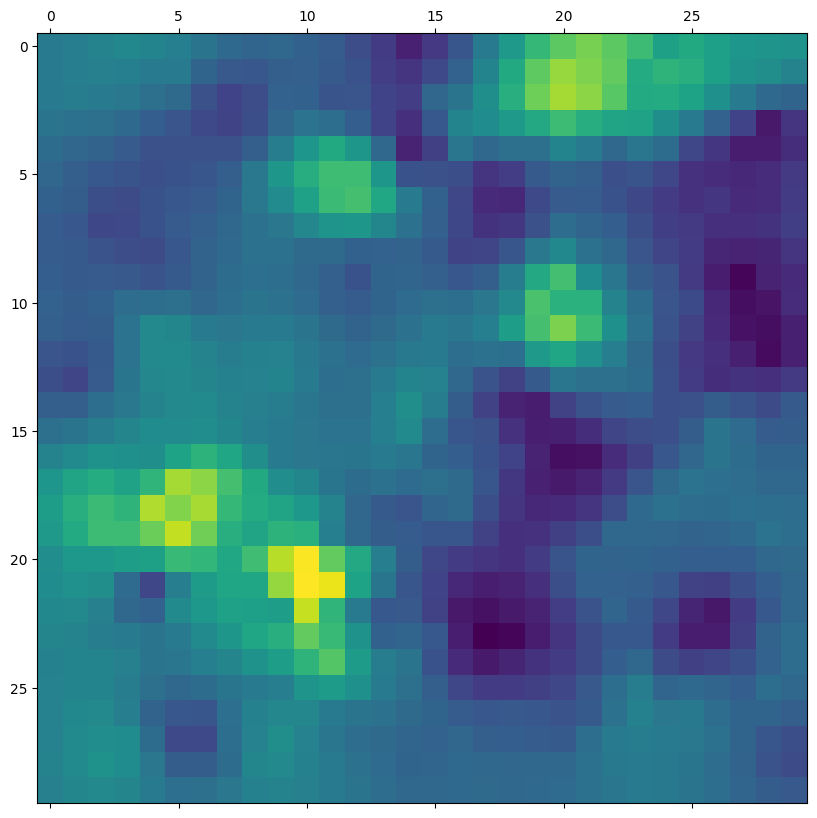

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

ax.matshow(M[:,::-1])
plt.show()

In [33]:
z = from_norm( M.ravel(), inv, param, mu, sd )
z = np.reshape(z, (xsteps, ysteps))
z.shape

(30, 30)

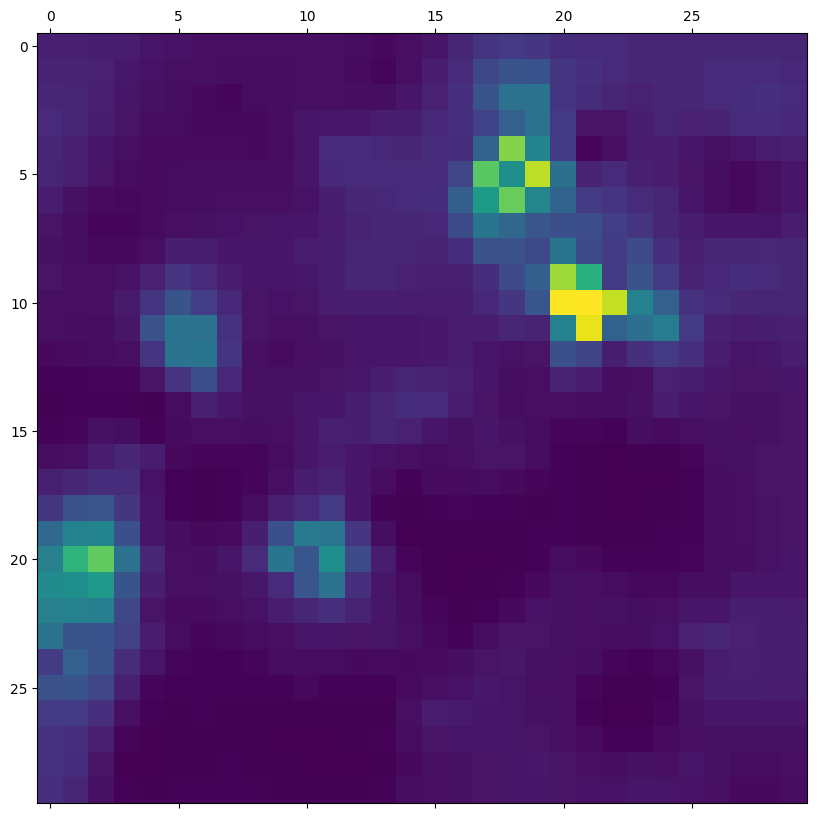

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

ax.matshow(z[:,::-1].T)
plt.show()

# Simple Kriging

In [35]:
zonea_url = 'https://github.com/cjohnson318/geostatsmodels/blob/master/data/ZoneA.dat?raw=true'

In [36]:
zonea = pd.read_csv(zonea_url, header=None, delim_whitespace=True, skiprows=10, names=['X', 'Y', 'Thick', 'Por', 'Perm', 'LogPerm', 'LogPermPrd', 'LogPermRsd'])
zonea

,X,Y,Thick,Por,Perm,LogPerm,LogPermPrd,LogPermRsd
0,12100,8300,37.1531,14.6515,2.8547,0.4556,0.1357,0.3198
1,5300,8700,31.4993,14.5093,-999.9999,-999.9999,-999.9999,-999.9999
2,3500,13900,36.9185,14.0639,-999.9999,-999.9999,-999.9999,-999.9999
3,5100,1900,24.0156,15.1084,1.1407,0.0572,0.2268,-0.1696
4,9900,13700,35.0411,13.9190,-999.9999,-999.9999,-999.9999,-999.9999
...,...,...,...,...,...,...,...,...
80,3500,7500,33.2246,15.1486,1.4744,0.1686,0.2348,-0.0662
81,3700,6900,30.6871,13.9584,-999.9999,-999.9999,-999.9999,-999.9999
82,14500,13300,39.6297,14.7381,2.9050,0.4631,0.1530,0.3102
83,4900,9100,31.2961,15.0689,-999.9999,-999.9999,-999.9999,-999.9999


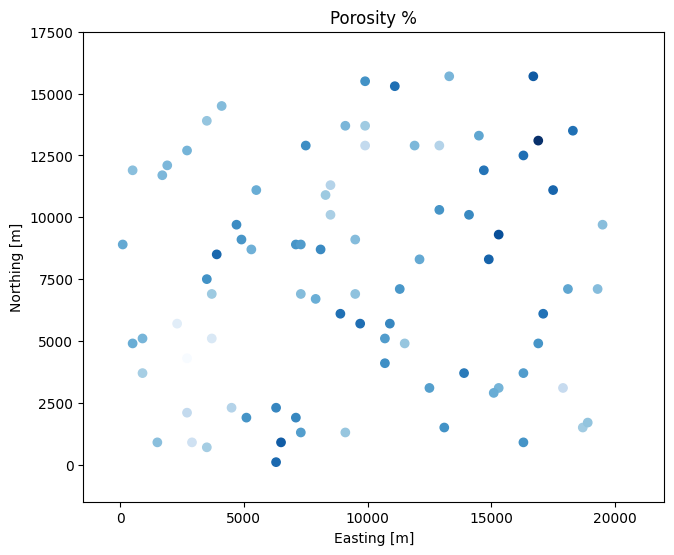

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 7.5))
ax.scatter(zonea.X, zonea.Y, c=zonea.Por, cmap='Blues')
ax.set_aspect(1)
ax.set_xlim(-1500,22000)
ax.set_ylim(-1500,17500)
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_title('Porosity %')

plt.show()

Semivariogram allows us to model the similarity points in a field as a function of distance.

$$
\hat{\gamma}(h)=\frac{1}{2N(h)} \sum_{N(h)} \left(z_{i}-z{j}\right)^{2}
$$

$h$ is the distance specified and $z_{i}$ and $z_{j}$ are two points separated spatially by $h$.